# Token Distortion by Vocabulary Order

**Goal:** Understand how the causal metric differentially stretches or compresses individual tokens based on their position in the vocabulary.

**Key question:** Do simple tokens (low IDs, common characters) get treated differently than complex tokens (high IDs, rare compounds) by the causal metric?

## The Setup

Each token has two norms:
- **Euclidean norm:** ||γᵢ||₂ = standard distance
- **Causal norm:** ||γᵢ||_M = distance under the causal metric M

**Distortion ratio:** R = ||γᵢ||_M / ||γᵢ||₂
- R = 1.0: No distortion (rare!)
- R > 1.0: Token is stretched (appears farther in probability space)
- R < 1.0: Token is compressed (appears closer in probability space)

## Vocabulary Order as Proxy for Complexity

BPE (byte-pair encoding) assigns token IDs during training:
- **Low IDs (0-1000):** Single bytes, common characters, frequent short tokens ('a', 'the', '\n')
- **Mid IDs (1000-100,000):** Common words and bigrams
- **High IDs (100,000+):** Rare merged sequences, technical terms, long compounds

**Hypothesis:** If distortion correlates with token ID, the model is treating simple vs. complex tokens differently in probability space.

## Configuration

In [1]:
# Model
MODEL_NAME = 'Qwen/Qwen3-4B-Instruct-2507'

# Data paths
METRIC_TENSOR_PATH = '../data/vectors/causal_metric_tensor_qwen3_4b.pt'

# Visualization parameters
SAMPLE_SIZE = None  # None = use all tokens, or set to e.g. 10000 for faster plotting
SMOOTHING_WINDOW = 1000  # Window size for rolling average trend line

print(f"Configuration:")
print(f"  Model: {MODEL_NAME}")
print(f"  Sample size: {'All tokens' if SAMPLE_SIZE is None else f'{SAMPLE_SIZE:,}'}")
print(f"  Smoothing window: {SMOOTHING_WINDOW:,}")

Configuration:
  Model: Qwen/Qwen3-4B-Instruct-2507
  Sample size: All tokens
  Smoothing window: 1,000


## Setup

In [2]:
import numpy as np
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

print("✓ Imports complete")

✓ Imports complete


## Load Model and Metric

In [3]:
print("Loading model and metric tensor...\n")

# Load model
print(f"Loading model from {MODEL_NAME}...")
print("  This will take a minute...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map='cpu',
)

# Load tokenizer (for looking up example tokens later)
print("\nLoading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Extract unembedding matrix
print("\nExtracting lm_head embeddings (gamma)...")
gamma = model.lm_head.weight.data.to(torch.float32).cpu()  # [vocab_size, hidden_dim]

# Load metric tensor
print(f"\nLoading causal metric tensor from {METRIC_TENSOR_PATH}...")
metric_data = torch.load(METRIC_TENSOR_PATH, weights_only=False)
M = metric_data['M'].to(torch.float32).cpu()  # [hidden_dim, hidden_dim]

vocab_size, hidden_dim = gamma.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Gamma shape: {gamma.shape}")
print(f"  M shape: {M.shape}")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading model and metric tensor...

Loading model from Qwen/Qwen3-4B-Instruct-2507...
  This will take a minute...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


Loading tokenizer...

Extracting lm_head embeddings (gamma)...

Loading causal metric tensor from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Gamma shape: torch.Size([151936, 2560])
  M shape: torch.Size([2560, 2560])


## Compute Norms

In [4]:
print("\n" + "=" * 80)
print("COMPUTING EUCLIDEAN AND CAUSAL NORMS")
print("=" * 80)

print(f"\nComputing Euclidean norms...")
euclidean_norms = torch.norm(gamma, dim=1)  # [vocab_size]

print(f"Computing causal norms...")
# Causal norm: sqrt(gamma^T M gamma) for each token
causal_norms = torch.sqrt((gamma @ M * gamma).sum(dim=1))  # [vocab_size]

print(f"\n✓ Norms computed\n")

# Summary statistics
print(f"Euclidean norms:")
print(f"  Mean: {euclidean_norms.mean():.4f}")
print(f"  Std: {euclidean_norms.std():.4f}")
print(f"  Range: [{euclidean_norms.min():.4f}, {euclidean_norms.max():.4f}]")

print(f"\nCausal norms:")
print(f"  Mean: {causal_norms.mean():.4f}")
print(f"  Std: {causal_norms.std():.4f}")
print(f"  Range: [{causal_norms.min():.4f}, {causal_norms.max():.4f}]")


COMPUTING EUCLIDEAN AND CAUSAL NORMS

Computing Euclidean norms...
Computing causal norms...

✓ Norms computed

Euclidean norms:
  Mean: 1.0873
  Std: 0.1681
  Range: [0.3595, 1.6050]

Causal norms:
  Mean: 54.1318
  Std: 7.9034
  Range: [21.3530, 85.2873]


## Compute Distortion Ratios

In [5]:
print("\n" + "=" * 80)
print("COMPUTING DISTORTION RATIOS")
print("=" * 80)

print(f"\nDistortion ratio: R = ||v||_causal / ||v||_euclidean")
distortion_ratios = (causal_norms / euclidean_norms).numpy()  # [vocab_size]

print(f"\n✓ Distortion ratios computed\n")

# Summary statistics
print(f"Distortion ratio statistics:")
print(f"  Mean: {distortion_ratios.mean():.4f}")
print(f"  Median: {np.median(distortion_ratios):.4f}")
print(f"  Std: {distortion_ratios.std():.4f}")
print(f"  Range: [{distortion_ratios.min():.4f}, {distortion_ratios.max():.4f}]")

print(f"\nPercentiles:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    val = np.percentile(distortion_ratios, p)
    print(f"  {p:2d}th: {val:.4f}")

# Find extreme tokens
most_compressed_idx = distortion_ratios.argmin()
most_stretched_idx = distortion_ratios.argmax()

print(f"\nExtreme tokens:")
print(f"  Most compressed (ID {most_compressed_idx}): '{tokenizer.decode([most_compressed_idx])}' - ratio {distortion_ratios[most_compressed_idx]:.4f}")
print(f"  Most stretched (ID {most_stretched_idx}): '{tokenizer.decode([most_stretched_idx])}' - ratio {distortion_ratios[most_stretched_idx]:.4f}")


COMPUTING DISTORTION RATIOS

Distortion ratio: R = ||v||_causal / ||v||_euclidean

✓ Distortion ratios computed

Distortion ratio statistics:
  Mean: 49.9726
  Median: 49.6525
  Std: 2.0732
  Range: [40.8718, 80.1588]

Percentiles:
   1th: 46.4858
   5th: 47.6734
  10th: 48.1420
  25th: 48.8668
  50th: 49.6525
  75th: 50.5449
  90th: 51.7897
  95th: 53.3275
  99th: 58.7506

Extreme tokens:
  Most compressed (ID 35696): ''));
' - ratio 40.8718
  Most stretched (ID 151645): '<|im_end|>' - ratio 80.1588


## Visualization: Distortion by Token ID


CREATING DISTORTION PLOT

Using all 151,936 tokens...
Computing smoothed trend line (window=1000)...


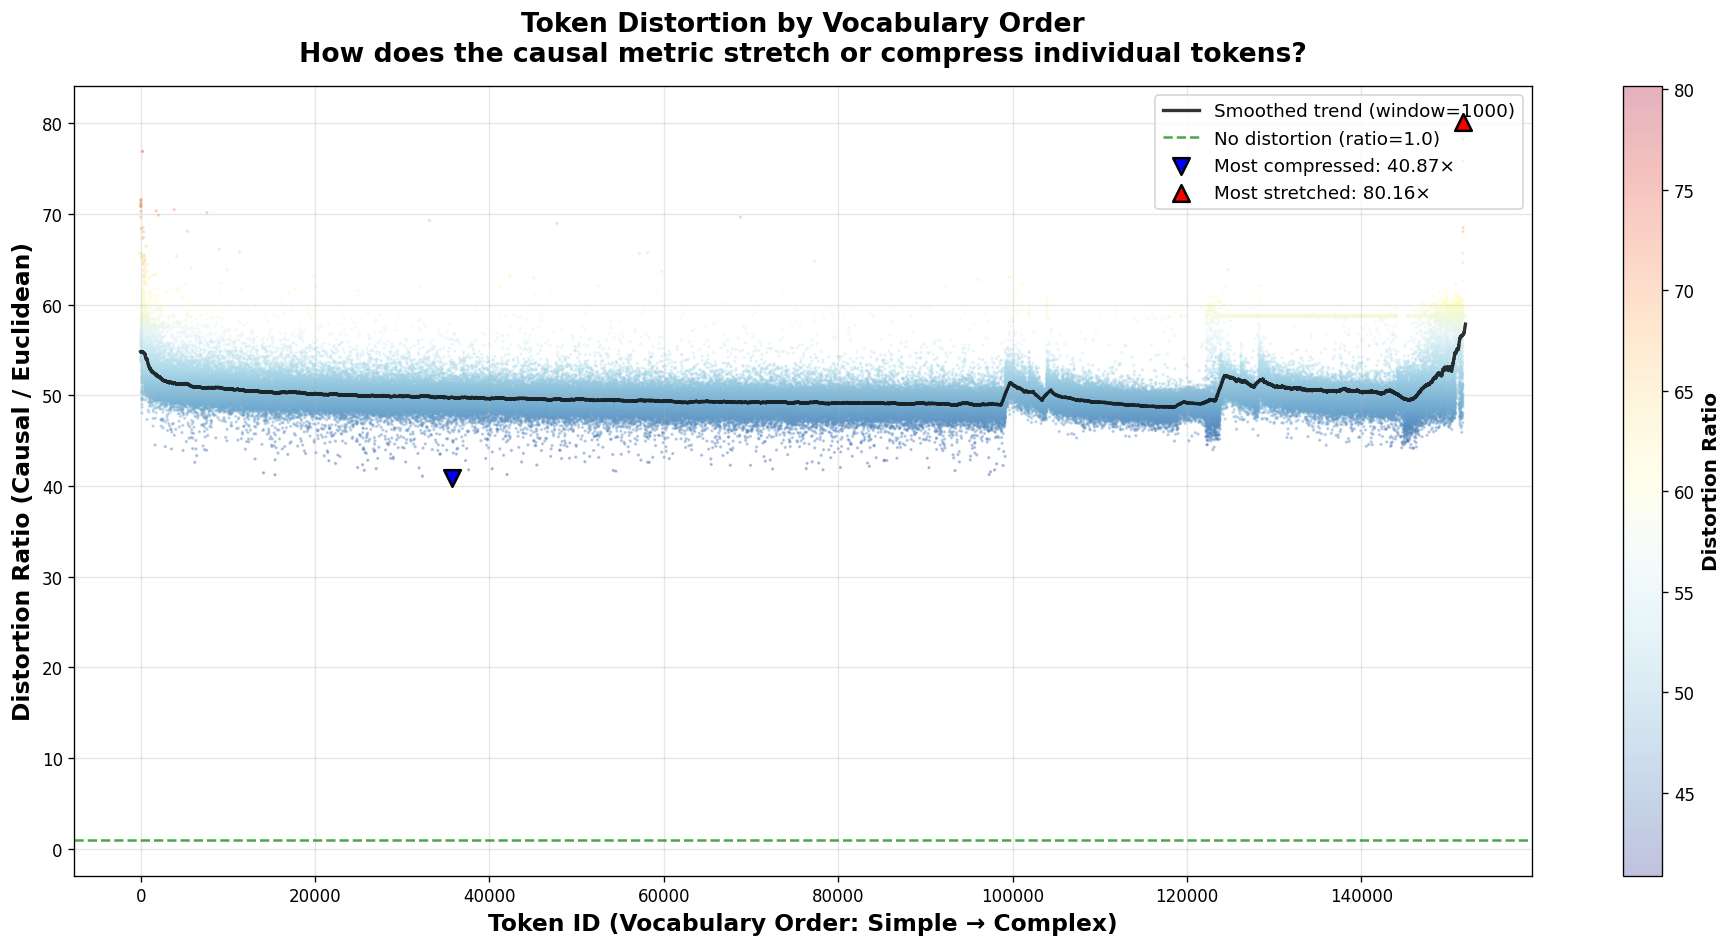


✓ Plot created


In [6]:
print("\n" + "=" * 80)
print("CREATING DISTORTION PLOT")
print("=" * 80)

# Sample if requested
if SAMPLE_SIZE is not None and SAMPLE_SIZE < vocab_size:
    print(f"\nSampling {SAMPLE_SIZE:,} tokens for visualization...")
    indices = np.random.choice(vocab_size, SAMPLE_SIZE, replace=False)
    indices.sort()
    token_ids_plot = indices
    distortion_plot = distortion_ratios[indices]
else:
    print(f"\nUsing all {vocab_size:,} tokens...")
    token_ids_plot = np.arange(vocab_size)
    distortion_plot = distortion_ratios

# Compute smoothed trend line
print(f"Computing smoothed trend line (window={SMOOTHING_WINDOW})...")
distortion_smoothed = uniform_filter1d(distortion_plot, size=SMOOTHING_WINDOW, mode='nearest')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8), dpi=120)

# Scatter plot with alpha for density
scatter = ax.scatter(
    token_ids_plot,
    distortion_plot,
    c=distortion_plot,
    cmap='RdYlBu_r',  # Red=stretched, Blue=compressed
    s=1,
    alpha=0.3,
    rasterized=True
)

# Add smoothed trend line
ax.plot(token_ids_plot, distortion_smoothed, 
        color='black', linewidth=2, alpha=0.8, label=f'Smoothed trend (window={SMOOTHING_WINDOW})')

# Reference line at ratio=1 (no distortion)
ax.axhline(1.0, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='No distortion (ratio=1.0)')

# Mark extreme tokens
ax.scatter([most_compressed_idx], [distortion_ratios[most_compressed_idx]], 
           color='blue', s=100, marker='v', edgecolor='black', linewidth=1.5,
           label=f'Most compressed: {distortion_ratios[most_compressed_idx]:.2f}×', zorder=10)
ax.scatter([most_stretched_idx], [distortion_ratios[most_stretched_idx]], 
           color='red', s=100, marker='^', edgecolor='black', linewidth=1.5,
           label=f'Most stretched: {distortion_ratios[most_stretched_idx]:.2f}×', zorder=10)

# Configure plot
ax.set_xlabel('Token ID (Vocabulary Order: Simple → Complex)', fontsize=14, fontweight='bold')
ax.set_ylabel('Distortion Ratio (Causal / Euclidean)', fontsize=14, fontweight='bold')
ax.set_title('Token Distortion by Vocabulary Order\nHow does the causal metric stretch or compress individual tokens?',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, label='Distortion Ratio')
cbar.set_label('Distortion Ratio', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Plot created")

## Sample Tokens at Different Positions

In [7]:
print("\n" + "=" * 80)
print("SAMPLE TOKENS FROM DIFFERENT VOCABULARY REGIONS")
print("=" * 80)

# Sample 10 tokens from different quintiles
n_samples = 10
quintiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

print(f"\nShowing {n_samples} random tokens from each quintile of vocabulary:\n")

for i in range(len(quintiles)-1):
    start_idx = int(quintiles[i] * vocab_size)
    end_idx = int(quintiles[i+1] * vocab_size)
    
    # Sample random tokens from this range
    sample_indices = np.random.choice(range(start_idx, end_idx), size=min(n_samples, end_idx-start_idx), replace=False)
    
    print(f"Quintile {i+1} (IDs {start_idx:,} - {end_idx:,}):")
    for idx in sorted(sample_indices):
        token_str = tokenizer.decode([idx])
        # Escape special characters for display
        token_display = repr(token_str)[1:-1]  # Remove outer quotes from repr
        distortion = distortion_ratios[idx]
        print(f"  ID {idx:6,}: '{token_display:30s}' - ratio {distortion:.4f}")
    print()


SAMPLE TOKENS FROM DIFFERENT VOCABULARY REGIONS

Showing 10 random tokens from each quintile of vocabulary:

Quintile 1 (IDs 0 - 30,387):
  ID     99: '�                             ' - ratio 54.3356
  ID  5,029: ' parameters                   ' - ratio 50.2002
  ID  6,716: ' pair                         ' - ratio 51.1340
  ID 12,046: 'aniel                         ' - ratio 50.5028
  ID 12,201: 'riting                        ' - ratio 49.8919
  ID 21,950: ' Represent                    ' - ratio 51.0179
  ID 22,086: '=b                            ' - ratio 52.4748
  ID 23,002: 'activation                    ' - ratio 48.7508
  ID 28,135: ' independently                ' - ratio 50.6282
  ID 28,180: ' reson                        ' - ratio 50.9378

Quintile 2 (IDs 30,387 - 60,774):
  ID 37,262: '-Compatible                   ' - ratio 48.7577
  ID 38,026: ' psi                          ' - ratio 49.0981
  ID 42,183: ' Ads                          ' - ratio 48.5991
  ID 43,004: 'annah 

## Distribution Analysis


DISTORTION DISTRIBUTION HISTOGRAM


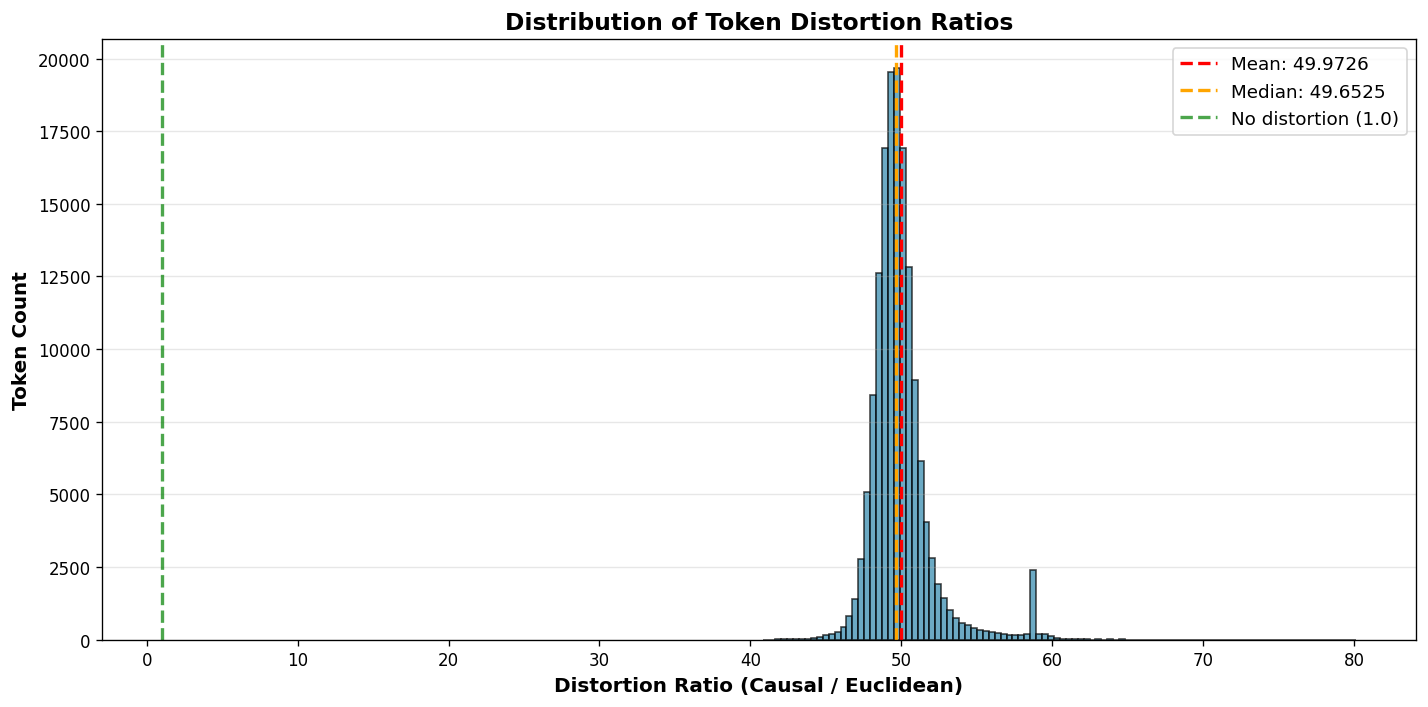


✓ Histogram created


In [8]:
print("\n" + "=" * 80)
print("DISTORTION DISTRIBUTION HISTOGRAM")
print("=" * 80)

fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Histogram
counts, bins, patches = ax.hist(distortion_ratios, bins=100, color='#2E86AB', alpha=0.7, edgecolor='black')

# Mark mean and median
ax.axvline(distortion_ratios.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {distortion_ratios.mean():.4f}')
ax.axvline(np.median(distortion_ratios), color='orange', linestyle='--', linewidth=2,
           label=f'Median: {np.median(distortion_ratios):.4f}')

# Mark ratio=1 (no distortion)
ax.axvline(1.0, color='green', linestyle='--', linewidth=2, alpha=0.7,
           label='No distortion (1.0)')

ax.set_xlabel('Distortion Ratio (Causal / Euclidean)', fontsize=12, fontweight='bold')
ax.set_ylabel('Token Count', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Token Distortion Ratios',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Histogram created")

## Summary

**What we measured:** How the causal metric distorts individual token norms compared to Euclidean space.

**Key findings:**
- Run the notebook to see results!

**Interpretation:**
- **Distortion ratio > 1:** Token appears farther away in probability space than Euclidean distance suggests
- **Distortion ratio < 1:** Token appears closer in probability space
- **Trend across vocabulary:** Does the smoothed line show correlation with token ID?
  - Flat line = no systematic difference between simple and complex tokens
  - Upward slope = complex tokens more stretched
  - Downward slope = simple tokens more stretched

**Physical meaning:** The causal metric reweights tokens based on how they affect the model's probability distribution. Tokens with high distortion ratios are "emphasized" - small Euclidean movements in their direction cause large changes in output probabilities.